In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from copy import deepcopy


**Note:** The dataset used in this implementation is sourced from the Deep Learning Specialization.


In [170]:
def load_data(transpose=True):
    train_dataset = h5py.File('/content/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/content/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    y_train = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    y_test = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    # Reshape the training and test examples
    train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
    test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

    # Standardize data to have feature values between 0 and 1.
    X_train = train_x_flatten/255.
    X_test = test_x_flatten/255.

    return X_train, y_train, X_test, y_test, classes



In [89]:
X_train, y_train, X_test, y_test, _ = load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



(12288, 209)
(1, 209)
(12288, 50)
(1, 50)


# Two Hidden Layer Neural Network Implementation

In this notebook, we will implement a two-hidden-layer neural network for binary classification problem from scratch using vectorized operations. The steps we will follow include:

1. **Parameter Initialization**: Initialize the parameters (weights and biases) for the neural network.
2. **Forward Propagation**: Implement the forward propagation step to compute the activations at each layer.
3. **Cost Function Computation**: Compute the cost function to measure the model's performance.
4. **Backward Propagation**: Implement the backward propagation step to compute gradients with respect to the parameters.
5. **Model**: Integrate all functions into a model that can train the neural network using gradient descent.
6. **Predict**: Use the trained model to make predictions on new data.

## 1. Parameter Initialization

We initialize the parameters for the neural network. The parameters include weights (`W`) and biases (`b`) for each layer. For a neural network with `L` layers (including the input layer, two hidden layers, and the output layer), the parameters will be stored in dictionaries.

### Function: `parameter_initialization(layer_dims)`
- **Input**:
  - `layer_dims` (a list containing the dimensions of each layer in the network, e.g., `[n_x, n_h1, n_h2, n_y]` where `n_x` is the number of input features, `n_h1` and `n_h2` are the number of units in the first and second hidden layers, and `n_y` is the number of output units).
  
- **Output**:
  - `parameters` (a dictionary containing initialized parameters `W` and `b` for each layer).
  
- **Dimension Constraints**:
  - `W[l].shape = (layer_dims[l], layer_dims[l-1])`
  - `b[l].shape = (layer_dims[l], 1)`
    -

In [90]:
def initialize_parameters(layer_dims):
    parameters = dict()

    for l in range(1, len(layer_dims)):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

In [91]:
# initalize_parameters_test
X_train, _, _, _, _ = load_data()
m = X_train.shape[1]
layer_dims = (m, 2, 1)

parameters = initialize_parameters(layer_dims)
print("shape of W1: ",parameters['W1'].shape)
print("shape of b1: ",parameters['b1'].shape)
print("shape of W2: ",parameters['W2'].shape)
print("shape of b2: ",parameters['b2'].shape)

shape of W1:  (2, 209)
shape of b1:  (2, 1)
shape of W2:  (1, 2)
shape of b2:  (1, 1)


## 3. Forward Propagation

The forward propagation step computes the activations for each layer, starting from the input layer to the output layer. The activation functions used in the layers are ReLU or sigmoid.

### Function: `forward_propagation(X, parameters)`
- **Input**:
  - `X` (input data of shape `(n_x, m)`)
  - `parameters` (a dictionary containing the parameters `W` and `b` for each layer)
- **Output**:
  - `A_L` (activation of the final layer, shape: `(1, m)`)
  - `caches` (list of caches containing intermediate values for use in backpropagation)

  #### Subroutine: `linear_activation_forward(A_prev, W, b, activation_type='relu')`
  - **Input**:
    - `A_prev` (shape: `(n_{l-1}, m)`)
    - `W` (shape: `(n_l, n_{l-1})`)
    - `b` (shape: `(n_l, 1)`)
    - `activation_type` ('relu' or 'sigmoid')
  - **Output**:
    - `AL` (shape: `(n_l, m)`)
    - `cache` (values for backpropagation)

  #### Subroutine: `linear_forward(A, W, b)`
  - **Input**:
    - `A` (shape: `(n_{l-1}, m)`)
    - `W` (shape: `(n_l, n_{l-1})`)
    - `b` (shape: `(n_l, 1)`)
  - **Output**:
    - `Z` (shape: `(n_l, m)`)
    - `cache` (values for backpropagation)

These subroutines are part of the `forward_propagation` function.


In [172]:
def linear_forward(A, W, b):

    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache

In [93]:
def linear_activation_forward(A_prev, W, b, activation_type='relu'):

    Z, linear_cache = linear_forward(A_prev, W, b)
    AL = None

    if activation_type == 'relu':
        AL = relu(Z)
    elif activation_type == 'sigmoid':
        AL = sigmoid(Z)
    activation_cache = Z

    cache = (linear_cache, activation_cache)
    return AL, cache



In [94]:
def forward_propagation(X, parameters):
    caches = []
    layers_len = len(parameters) // 2

    ###### HIDDEN LAYERS ######
    A_prev = X
    for l in range(1, layers_len):

        W_l = parameters['W' + str(l)]
        b_l = parameters['b' + str(l)]

        A_l, cache = linear_activation_forward(A_prev, W_l, b_l, activation_type='relu')
        caches.append(cache)
        A_prev = A_l

    ###### OUTPUT LAYER ######
    W_L = parameters['W' + str(layers_len)]
    b_L = parameters['b' + str(layers_len)]
    A_L, cache = linear_activation_forward(A_prev, W_L, b_L, activation_type="sigmoid")
    caches.append(cache)
    return A_L, caches



In [95]:
# forward_propagation_test
X_train, _, _, _, _ = load_data()
layer_dims = (X_train.shape[0], 2, 1)

initial_params = initialize_parameters(layer_dims)
A_L, caches = forward_propagation(X_train, parameters=initial_params)
A_L.shape

(1, 209)

## 2. Compute Cost

The `compute_cost` function calculates the cost of the predictions made by the model using binary cross-entropy loss.

### Function: `compute_cost(A_L, Y)`
- **Input**:
  - `A_L` (activation of the final layer, shape: `(n_L, m)`)
  - `Y` (true labels, shape: `(n_L, m)`)
- **Output**:
  - `cost` (scalar value representing the cost)

In [96]:
def compute_cost(A_L, Y):
    m = Y.shape[1]

    # Compute the binary cross-entropy cost
    cost = - (1 / m) * np.sum(Y * np.log(A_L) + (1 - Y) * np.log(1 - A_L))

    return cost

In [97]:
# compute_cost_test

A_L = np.array([[0.99, 0.1, 0.99]])
Y = np.array([[1, 0, 1]])

cost = compute_cost(A_L, Y)
print(f"Cost: {cost}")


Cost: 0.0418203957882764


## 4. Backpropagation

The backpropagation step computes the gradients for each layer, starting from the output layer and moving backward through the network. It uses cached values from forward propagation to compute gradients for weights, biases, and activations.

### Function: `backpropagation(A_L, Y, caches)`
- **Input**:
  - `A_L` (activation of the final layer, shape: `(1, m)`)
  - `Y` (true labels, shape: `(n_L, m)`)
  - `caches` (list of caches from forward propagation, each cache contains `(linear_cache, activation_cache)`)
- **Output**:
  - `gradients` (dictionary containing gradients for each layer: `dA_prev`, `dW`, and `db`)

  #### Subroutine: `backward_step(dA, cache, activation_type='relu')`
  - **Input**:
    - `dA` (gradient of the activation, shape: `(n_l, m)`)
    - `cache` (tuple of `(linear_cache, activation_cache)`, where `linear_cache` contains `(A_prev, W, b)` and `activation_cache` contains `Z`)
    - `activation_type` ('relu' or 'sigmoid')
  - **Output**:
    - `dA_prev` (gradient of the previous layer, shape: `(n_{l-1}, m)`)
    - `dW` (gradient of the weights, shape: `(n_l, n_{l-1})`)
    - `db` (gradient of the bias, shape: `(n_l, 1)`)

  This subroutine computes the gradient of the loss function with respect to the activation, weights, and bias for a given layer.

These subroutines are used within the `backpropagation` function to calculate the gradients necessary for updating the network parameters during training.


In [176]:
def relu_backward(dA, Z):
    """
    Implement the backward propagation for a single ReLU unit.

    Arguments:
    dA -- Gradient of the loss with respect to the activation output of the current layer (same shape as Z)
    Z -- Linear output of the current layer (before activation), same shape as dA

    Returns:
    dZ -- Gradient of the loss with respect to Z (same shape as Z)
    """

    # Ensure dA and Z have the same shape
    assert dA.shape == Z.shape, f"dA shape {dA.shape} does not match Z shape {Z.shape}"

    dZ = np.array(dA, copy=True)  # Copy dA to dZ
    dZ[Z <= 0] = 0  # Set dZ to 0 where Z is less than or equal to 0

    return dZ

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    dZ = dA * sig * (1 - sig)
    return dZ

In [119]:


def backward_step(dA, cache, activation_type='relu'):
    linear_cache, activation_cache = cache
    A_prev, W, b = linear_cache
    Z = activation_cache
    m = A_prev.shape[1]

    if activation_type == 'relu':
        dZ = relu_backward(dA, Z)
    elif activation_type == 'sigmoid':
        dZ = sigmoid_backward(dA, Z)

    dA_prev = np.dot(W.T, dZ)
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m

    return dA_prev, dW, db

In [125]:
def backpropagation(A_L, Y, caches):
  gradients = {}
  m = A_L.shape[1]
  dA_L = - (np.divide(Y, A_L) - np.divide(1 - Y, 1 - A_L))
  L = len(caches)


  # Lth Layer
  dA_prev, dW, db = backward_step(dA_L, caches[-1], activation_type='sigmoid')

  gradients['dA'+str(L-1)] = dA_prev
  gradients['dW'+str(L)] = dW
  gradients['db'+str(L)] = db
  for l in range(L-2, -1, -1):
      dA_prev, dW, db = backward_step(dA_prev, caches[l], activation_type='relu')

      gradients['dA'+str(l)] = dA_prev
      gradients['dW'+str(l+1)] = dW
      gradients['db'+str(l+1)] = db


  return gradients


In [100]:
def update_parameters(parameters, grads, learning_rate):
  L = len(parameters) // 2
  params = deepcopy(parameters)

  for l in range(1, L):
      params['W'+str(l)] = params['W'+str(l)] - learning_rate * grads['dW'+str(l)]
      params['b'+str(l)] = params['b'+str(l)] - learning_rate * grads['db'+str(l)]

  return params

In [168]:
def model(X, Y, initial_params, learning_rate=0.01, iterations=1000):
    parameters = initial_params
    costs = []
    for i in range(iterations):
        A_L, caches = forward_propagation(X, parameters)

        # Compute cost
        cost = compute_cost(A_L, Y)
        costs.append(cost)
        # Backward propagation
        gradients = backpropagation(A_L, Y, caches)

        # Update parameters
        parameters = update_parameters(parameters, gradients, learning_rate)

    if i % 100 == 0:
        print(f"Iteration {i}: Cost = {cost}")

    plt.plot(range(iterations), costs)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost vs. Iteration')
    plt.show()
    return parameters, costs

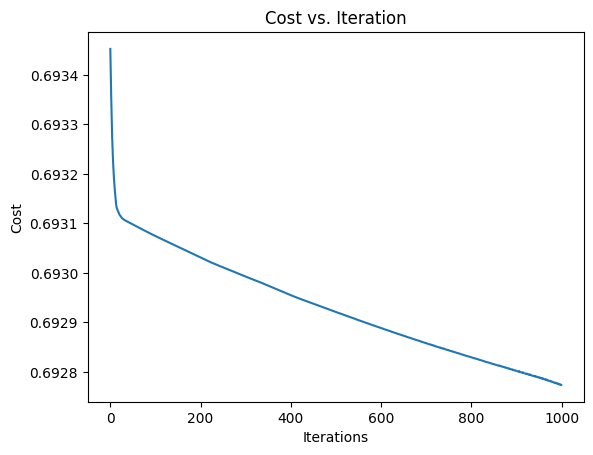

In [175]:
# model_test
X_train, y_train, X_test, y_test, _ = load_data()
layer_dims = (X_train.shape[0],2, 1)

initial_params = initialize_parameters(layer_dims)
parameters, costs = model(X_train, y_train, initial_params)